In [1]:
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import os

2025-11-02 18:17:41.963162: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-02 18:17:42.780528: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-02 18:17:44.781117: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


# 1. Carga de datos

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# 2. Preprocesamiento

In [3]:
# Normalización
x_train = x_train / 255.0
x_test = x_test / 255.0

# Convertir etiquetas a par (0) / impar (1)
y_train = (y_train % 2).astype(np.float32)
y_test = (y_test % 2).astype(np.float32)

print(f"\nDistribución en train:")
print(f"  Pares: {np.sum(y_train == 0)} ({np.sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  Impares: {np.sum(y_train == 1)} ({np.sum(y_train == 1)/len(y_train)*100:.1f}%)")


Distribución en train:
  Pares: 29492 (49.2%)
  Impares: 30508 (50.8%)


# 3. Configuraciones a evaluar

In [4]:
# Valores posibles para cada parámetro
param_values = {
    'hidden_neurons': [512],
    'epochs': [15],
    'loss': ['binary_crossentropy'],
    'batch_size': [256],
    'lr': [0.001],
    'validation_split': [0.1]
}

param_names = list(param_values.keys())
param_combinations = list(product(*param_values.values()))

configurations = []
for i, combination in enumerate(param_combinations, 1):
    config = {'name': f'Config_{i}'}
    for param_name, param_value in zip(param_names, combination):
        config[param_name] = param_value
    configurations.append(config)

for config in configurations:
    print(f"{config['name']:>10} | "
          f"neurons={config['hidden_neurons']:>3} | "
          f"epochs={config['epochs']:>2} | "
          f"batch={config['batch_size']:>3} | "
          f"lr={config['lr']:.4f} | "
          f"val_split={config['validation_split']:.1f}")

  Config_1 | neurons=512 | epochs=15 | batch=256 | lr=0.0010 | val_split=0.1


# 4. Función para crear modelos

In [5]:


def create_model(hidden_neurons: int = 128) -> tf.keras.models.Sequential:
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    model.add(tf.keras.layers.Dense(hidden_neurons, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

# 5. Función de evaluación completa

In [6]:


def evaluate_model(model: tf.keras.models.Sequential, x_test: np.ndarray, y_test: np.ndarray) -> dict:
    results = {}

    # Accuracy y loss en test
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

    # Predicciones (para clasificación binaria con sigmoid)
    y_pred_probs = model.predict(x_test, verbose=0).flatten()
    y_pred = (y_pred_probs > 0.5).astype(int)

    errors = np.sum(y_pred != y_test)

    print(f"Errors:  {errors}/{len(y_test)} ({errors/len(y_test)*100:.2f}%)")

    # Matrices de confusión (par vs impar)
    cm = confusion_matrix(y_test, y_pred)

    # Guardar resultados
    results['loss'] = loss
    results['accuracy'] = accuracy
    results['errors'] = errors
    results['cm'] = cm
    results['predictions'] = y_pred

    return results

# 6. Entrenamiento de todas las configuraciones

In [7]:
all_results = {}
all_histories = {}

for config in configurations:
    name = config['name']
    print(f"\n{'▶'*3} Configuración: {name}")
    print(f"    Neuronas capa oculta: {config['hidden_neurons']}")
    print(f"    Épocas: {config['epochs']}")
    print(f"    Loss: {config['loss']}")
    print(f"    Batch size: {config['batch_size']}")
    print(f"    Learning rate: {config['lr']}")
    print(f"    Validation split: {config['validation_split']}")
    print(f"    Optimizer: Adam (fijo)")

    model = create_model(hidden_neurons=int(config['hidden_neurons']))
    optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'])

    model.compile(
        optimizer=optimizer,
        loss=config['loss'],
        metrics=['accuracy']
    )

    # Entrenar y medir tiempo
    start_time = time.time()
    history = model.fit(
        x_train, y_train,
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        validation_split=config['validation_split'],
        verbose=1
    )
    elapsed_time = time.time() - start_time

    print(f"\n⏱️  Tiempo de entrenamiento: {elapsed_time:.2f} segundos")

    val_loss = history.history['val_loss'][-1]
    val_accuracy = history.history['val_accuracy'][-1]

    # Guardar
    all_histories[name] = history
    all_results[name] = {
        'config': config,
        'model': model,
        'training_time': elapsed_time,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    }


▶▶▶ Configuración: Config_1
    Neuronas capa oculta: 512
    Épocas: 15
    Loss: binary_crossentropy
    Batch size: 256
    Learning rate: 0.001
    Validation split: 0.1
    Optimizer: Adam (fijo)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-11-02 18:17:45.620836: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9348 - loss: 0.1650 - val_accuracy: 0.9695 - val_loss: 0.0897
Epoch 2/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9756 - loss: 0.0718 - val_accuracy: 0.9787 - val_loss: 0.0665
Epoch 3/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9823 - loss: 0.0521 - val_accuracy: 0.9812 - val_loss: 0.0585
Epoch 4/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9865 - loss: 0.0412 - val_accuracy: 0.9815 - val_loss: 0.0549
Epoch 5/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9898 - loss: 0.0319 - val_accuracy: 0.9830 - val_loss: 0.0498
Epoch 6/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9925 - loss: 0.0251 - val_accuracy: 0.9838 - val_loss: 0.0513
Epoch 7/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9931 - loss: 0.0224 - val_accuracy: 0.9855 - val_loss: 0.0489
Epoch 8/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9954 - loss: 0.0165 - val_accuracy: 0.

# 7. Tabla comparativa de resultados

In [8]:

comparison_data = []
for name, results in all_results.items():
    comparison_data.append({
        'Configuración': name,
        'Neuronas': results['config']['hidden_neurons'],
        'Épocas': results['config']['epochs'],
        'Loss': results['config']['loss'],
        'Batch Size': results['config']['batch_size'],
        'LR': results['config']['lr'],
        'Val Split': results['config']['validation_split'],
        'Val Loss': f"{results['val_loss']:.4f}",
        'Val Accuracy': f"{results['val_accuracy']:.4f}",
        'Tiempo (s)': f"{results['training_time']:.2f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

# Guardar a CSV
os.makedirs('results', exist_ok=True)
df_comparison.to_csv('results/comparison_table.csv', index=False)
print("\n💾 Tabla guardada en: results/comparison_table.csv")

# Identificar mejor configuración
best_config = max(all_results.items(), key=lambda x: x[1]['val_accuracy'])
print(f"\n🏆 MEJOR CONFIGURACIÓN: {best_config[0]}")
print(f"   Val Accuracy: {best_config[1]['val_accuracy']:.4f}")
print(f"   Val Loss: {best_config[1]['val_loss']:.4f}")
print(f"   Training Time: {best_config[1]['training_time']:.2f}s")

Configuración  Neuronas  Épocas                Loss  Batch Size    LR  Val Split Val Loss Val Accuracy Tiempo (s)
     Config_1       512      15 binary_crossentropy         256 0.001        0.1   0.0573       0.9865      20.81

💾 Tabla guardada en: results/comparison_table.csv

🏆 MEJOR CONFIGURACIÓN: Config_1
   Val Accuracy: 0.9865
   Val Loss: 0.0573
   Training Time: 20.81s


# 8. Evaluación de la mejor configuración

In [9]:
results_test = evaluate_model(all_results[best_config[0]]['model'], x_test, y_test)

print(f"\n✅ RESULTADOS FINALES DEL MEJOR MODELO:")
print(f"   Config: {best_config[0]}")
print(f"   Test Accuracy: {results_test['accuracy']:.4f}")
print(f"   Test Loss: {results_test['loss']:.4f}")
print(f"   Test Errors: {results_test['errors']}/{len(y_test)}")

Loss: 0.0430, Accuracy: 0.9890
Errors:  110/10000 (1.10%)

✅ RESULTADOS FINALES DEL MEJOR MODELO:
   Config: Config_1
   Test Accuracy: 0.9890
   Test Loss: 0.0430
   Test Errors: 110/10000


# 9. Visualizaciones comparativas

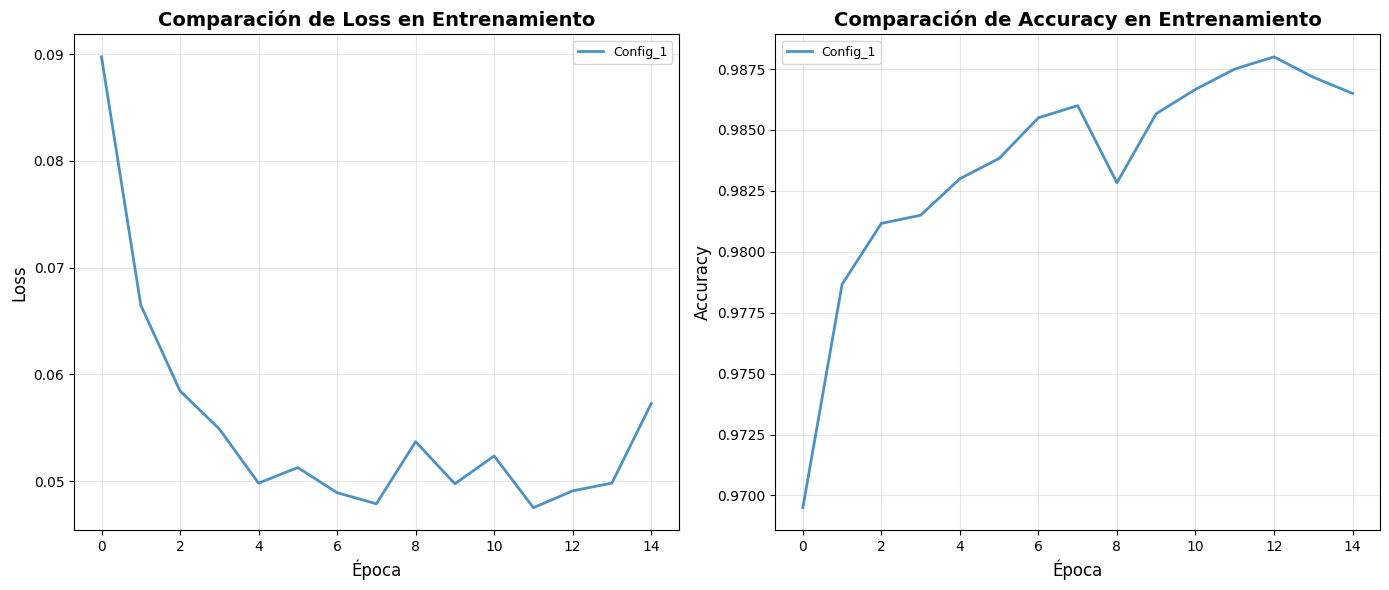

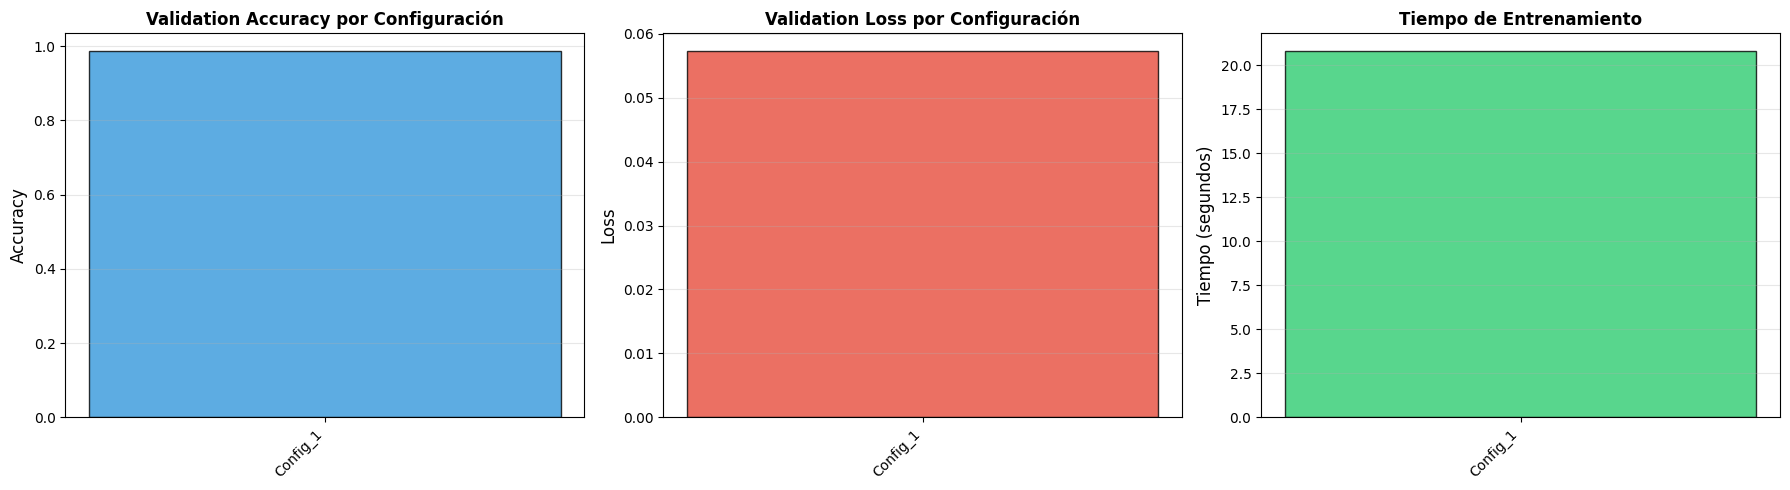

In [10]:
# Gráfica comparativa: Loss durante entrenamiento
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for name, history in all_histories.items():
    plt.plot(history.history['val_loss'], label=name, linewidth=2, alpha=0.8)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Comparación de Loss en Entrenamiento', fontsize=14, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for name, history in all_histories.items():
    plt.plot(history.history['val_accuracy'], label=name, linewidth=2, alpha=0.8)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparación de Accuracy en Entrenamiento', fontsize=14, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Gráfica de barras: Accuracy final
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Validation Accuracy
config_names = list(all_results.keys())
val_accs = [all_results[name]['val_accuracy'] for name in config_names]

axes[0].bar(range(len(config_names)), val_accs, color='#3498db', alpha=0.8, edgecolor='black')
axes[0].set_xticks(range(len(config_names)))
axes[0].set_xticklabels(config_names, rotation=45, ha='right')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Validation Accuracy por Configuración', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Validation Loss
val_losses = [all_results[name]['val_loss'] for name in config_names]

axes[1].bar(range(len(config_names)), val_losses, color='#e74c3c', alpha=0.8, edgecolor='black')
axes[1].set_xticks(range(len(config_names)))
axes[1].set_xticklabels(config_names, rotation=45, ha='right')
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Validation Loss por Configuración', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Training Time
train_times = [all_results[name]['training_time'] for name in config_names]

axes[2].bar(range(len(config_names)), train_times, color='#2ecc71', alpha=0.8, edgecolor='black')
axes[2].set_xticks(range(len(config_names)))
axes[2].set_xticklabels(config_names, rotation=45, ha='right')
axes[2].set_ylabel('Tiempo (segundos)', fontsize=12)
axes[2].set_title('Tiempo de Entrenamiento', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 10. Matriz de Confusión del Mejor Modelo

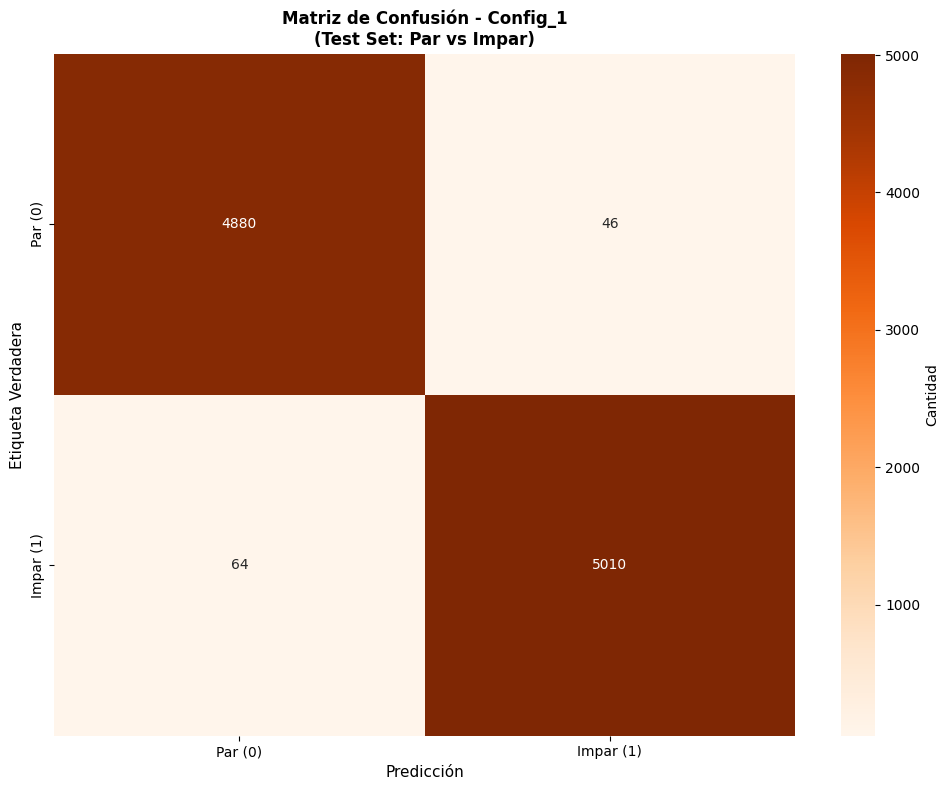

In [11]:

best_name = best_config[0]
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.heatmap(results_test['cm'], annot=True, fmt='d', cmap='Oranges',
            ax=ax, cbar_kws={'label': 'Cantidad'},
            xticklabels=['Par (0)', 'Impar (1)'],
            yticklabels=['Par (0)', 'Impar (1)'])
ax.set_xlabel('Predicción', fontsize=11)
ax.set_ylabel('Etiqueta Verdadera', fontsize=11)
ax.set_title(f'Matriz de Confusión - {best_name}\n(Test Set: Par vs Impar)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f'results/confusion_matrix_best_{best_name}.png', dpi=150, bbox_inches='tight')
plt.show()